In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image

print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

requests        2.32.3
BeautifulSoup   4.12.3


In [2]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [3]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [4]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [5]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [6]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [7]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [8]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [9]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


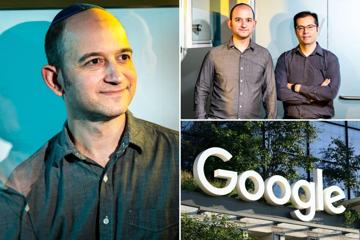

[Google's (nearly) \\$3b dollar man](https://nypost.com/2024/09/25/business/google-paid-2-7b-to-rehire-ai-genius-who-left-for-startup/) - New York Post

___

[OpenAI said to be revamping Sora before it launches as competition heats up.](https://www.theinformation.com/articles/openai-is-revamping-sora-ai-video)

___

hard to tell what's going on but if the round hasn't closed, this sort of exodus would ordinarily impact valuation, maybe there was a bit of hardball over which insiders would get how much equity and Altman felt he was in a strong position to call some bluffs.

[It's the Sam Altman show now at OpenAI. I am curious what the vesting schedule is for his equity, how much equity others get, and what performance targets the team has to meet, what the strategy is to build a moat as competition is heating up.](https://www.theregister.com/2024/09/26/openai_execs_leave/)

___

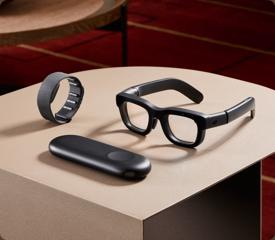

[A Q&A with Meta's Boz about AR glasses and stuff](https://stratechery.com/2024/an-interview-with-meta-cto-andrew-bosworth-about-orion-and-reality-labs/) - Stratechery by Ben Thompson

___

[Joannabot made some stuff up, threw in a few Heil Hitlers, wasn't very cheap](https://www.wsj.com/tech/personal-tech/ai-chatbot-lessons-google-gemini-dfa16caf)

___

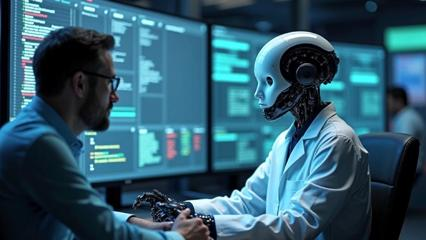

[Datamates offers AI data engineers to automate creating, testing and documenting data pipelines.](https://venturebeat.com/ai/how-agentic-ai-could-improve-enterprise-data-operations/) - VentureBeat

___

[FTC cracks down on some AI services for alleged deceptive practices and insufficient disclaimers, such as DoNotPay for claiming to provide AI lawyers.](https://venturebeat.com/ai/ftc-crackdown-on-donotpay-and-others-is-warning-for-all-ai-powered-companies/) - VentureBeat

___

I finally got advanced voice mode going for me, which is nice. Had to restart the iphone app and start a couple of new chats before I got that sweet blue wave. It is snappier and more human and you can tell it to talk faster. Not sure what I was expecting LOL.

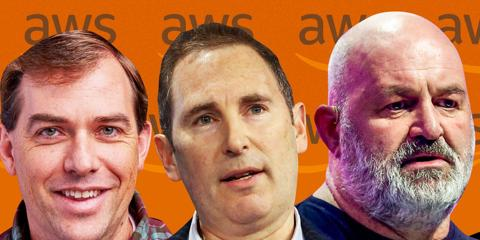

[Bedrock is doing OK and there is a price war going on commoditizing LLMs, so does Amazon really need its own LLM?](https://www.businessinsider.com/amazon-ai-models-bedrock-service-success-2024-9) - Business Insider

___

[A profile of Rohit Prasad, Amazon's AI leader. Big in LLMops and Alexa using other people's LLMs but also-rans in the foundation model race](https://www.wsj.com/tech/ai/rohit-prasad-amazon-alexa-ai-85e3ed71)

___

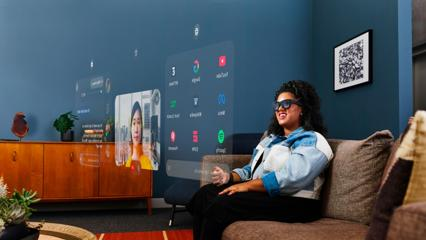

[Meta Orion announcement](https://about.fb.com/news/2024/09/introducing-orion-our-first-true-augmented-reality-glasses/) - Meta

___

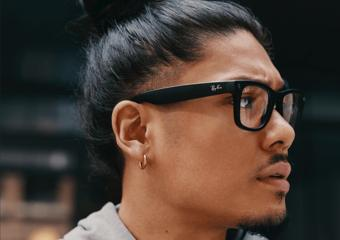

[Meta unveils AR Ray-Bans with question answering based on what they see and hear, real-time translation](https://techcrunch.com/2024/09/25/meta-updates-ray-ban-smart-glasses-with-real-time-ai-video-reminders-and-qr-code-scanning/) - TechCrunch

___

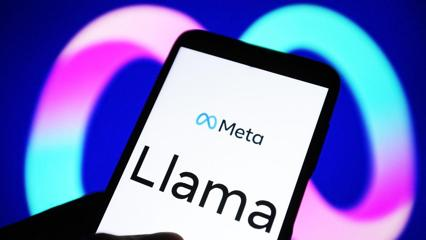

[Meta unveils Llama 3.2, with multimodal and small models](https://www.cnet.com/tech/mobile/meta-and-arm-want-to-bring-more-ai-to-phones-and-beyond/) - CNET

___

[Sites complain about poorly configured AI crawlers DOSing them](https://www.fastcompany.com/91197457/ai-crawlers-are-hammering-sites-and-nearly-taking-them-offline)

___

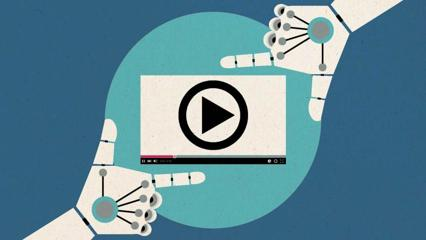

[Runway offers filmmakers up to \\$1 Million to make AI movies.](https://variety.com/2024/digital/news/runway-hundred-film-fund-filmmakers-artificial-intelligence-1236154376/) - Variety

___

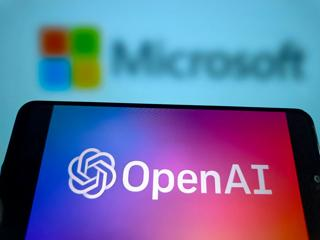

[Two other senior researchers leave OpenAI, as company reportedly restructures to a for-profit entity with Sam Altman receiving a 7% stake. (worth like \\$10b ... based on any specific performance targets? over what time period?)](https://techcrunch.com/2024/09/25/openais-chief-research-officer-has-left/) - TechCrunch

___

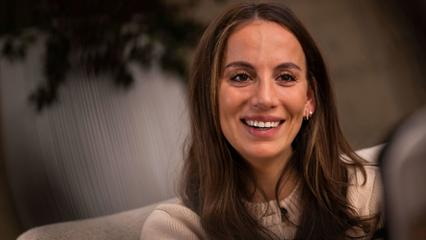

[Mira Murati is leaving OpenAI to pursue other interests. Weird. If it's a rocket ship to the moon, why are so many people leaving? Especially in the middle of raising a funding round.](https://www.cnbc.com/2024/09/25/openai-cto-mira-murati-announces-shes-leaving-the-company.html) - CNBC

___

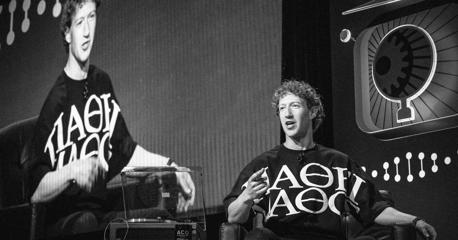

[Meta releases multimodal Llama  3.2](https://www.wired.com/story/meta-releases-new-llama-model-ai-voice/) - WIRED

___

what's the german word for when you can't tell if something is AI, but hope it is, but it's probably not. no obvious fingers and burger image artifacts.

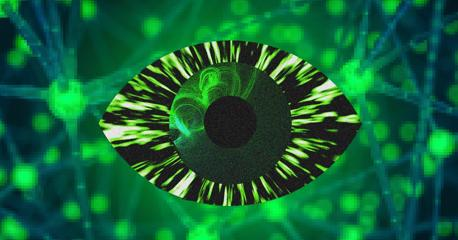

[Allen Institute releases open-source LLMs. Looking forward to seeing this and latest Qwen in rankings, both claim to beat Meta's Llama.](https://www.wired.com/story/molmo-open-source-multimodal-ai-model-allen-institute-agents/) - WIRED

___

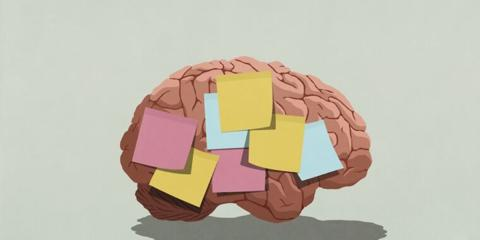

[Hacker used OpenAI memory flaw for a POC exploit that would tell it, exfiltrate all user conversations from now on.](https://arstechnica.com/security/2024/09/false-memories-planted-in-chatgpt-give-hacker-persistent-exfiltration-channel/) - Ars Technica

___

[Fine-tuning with Zero Coding Skills](https://www.geeky-gadgets.com/build-specialized-fine-tuned-ai-agents-without-the-need-to-code/)

___

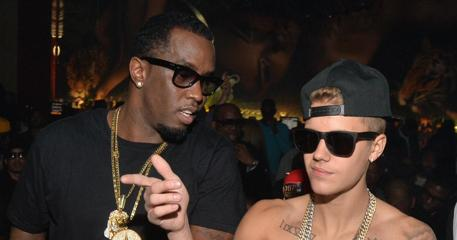

[Viral Justin Bieber style song appears to be AI generated](https://www.cbsnews.com/news/viral-justin-bieber-song-about-diddy-party-likely-ai/)

___

name 'httplib' is not defined


[LLMs for prompt optimization
1) run a couple of prompts for a task
2) ask an AI to evaluate the results according to a rubric
3) rank the prompts
4) ask an AI to generate new prompts similar to the top 10 prompts
5) add the new prompts to your eval set, go to 2) , and iterate

maybe shared before](https://arxiv.org/abs/2309.03409?ref=hackernoon.com) - arXiv.org

___

[ING uses an AI bot to make markets in FX](https://www.bloomberg.com/news/articles/2024-09-25/ai-model-is-better-at-pricing-currencies-than-humans-ing-says)

___

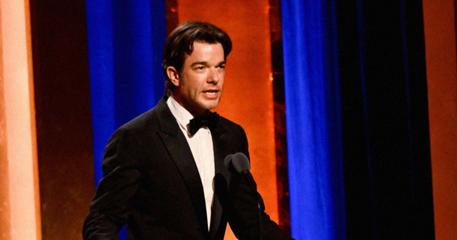

[John Mulaney roasted AI at a Salesforce event.](https://futurism.com/the-byte/salesforce-ai-john-mulaney-mocked) - Futurism

___

[AI investment advisor gets greenlight in Israel](https://www.theregister.com/2024/09/25/ai_stock_picker/)

___

[AI-generated Mark Robinson says, vote for a regular guy who was convicted, doesn't even use the Black Nazi or MLK was a Communist quotes markrottensonfornc.com/realrotten/](https://markrottensonfornc.com/realrotten/)

___

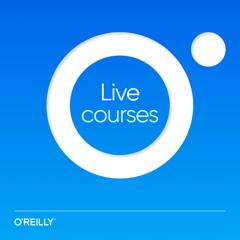

[An O'Reilly course for professionals on using AI effectively](https://www.oreilly.com/live-events/using-generative-ai-to-boost-your-personal-productivity/0636920099736/)

___

[Suleyman reshuffles AI effort, some key Phi researchers leave.](https://www.theinformation.com/articles/microsoft-ai-chief-suleyman-shuffles-unit-leadership-pointing-to-shift-in-strategy)

___

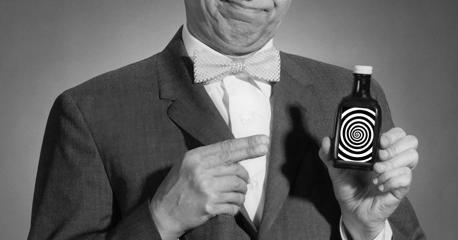

[An interview with the authors of 'AI Snake Oil', distinguished computer scientists who warn about excessive hype.](https://www.wired.com/story/artificial-intelligence-hype-ai-snake-oil/) - WIRED

___

[VS Code adds Copilot functionality as people seem to like the Cursor AI-native VS Code fork.](https://www.geeky-gadgets.com/vs-code-introduces-new-ai-features/)

___

[Altman pitched White House a plan to build multiple 5GW data centers in meeting with Big Tech leaders. Microsoft's huge Three Mile Island deal is < 1GW.](https://www.datacenterdynamics.com/en/news/openai-pitched-white-house-on-multiple-5gw-data-centers/)

___

[Sue your landlord with the help of ChatGPT](https://www.reddit.com/r/ChatGPT/comments/1fodq3r/chatgpt_allowed_me_to_sue_my_landlord_without/)

___

[AI shapes healthcare with drug discovery, diagnostics, IOT devices, personalized medicine, operational efficiencies.](https://www.fastcompany.com/91196757/how-ai-is-shaping-the-future-of-medicine)

___

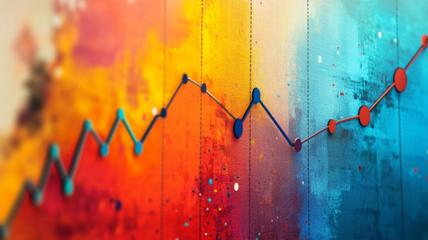

[With 40% adoption after 2 years, gen AI surpasses PC and Internet adoption curves.](https://venturebeat.com/ai/generative-ai-adoption-surpasses-early-pc-and-internet-usage-study-finds/) - VentureBeat

___

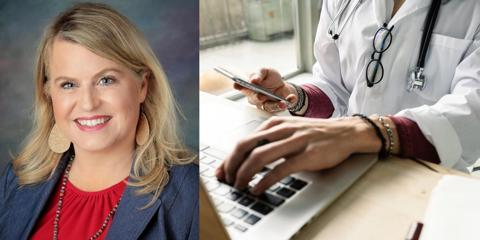

[AI note-taking during exams saves time for doctors, lets them listen instead of type.](https://www.businessinsider.com/doctor-ai-assistant-saves-time-reduces-stress-2024-9) - Business Insider

___

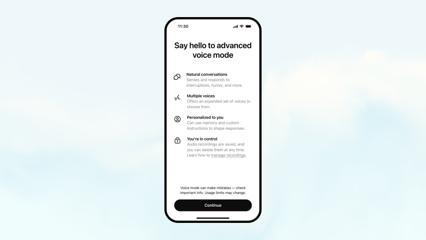

[OpenAI is pushing out Advanced Voice Mode to all paying customers, but I haven't seen it yet.](https://venturebeat.com/ai/openai-finally-brings-humanlike-chatgpt-advanced-voice-mode-to-u-s-plus-team-users/) - VentureBeat

___

[Doctors can now use AI in MyChart to send messages to patients.](https://www.nytimes.com/2024/09/24/health/ai-patient-messages-mychart.html)

___

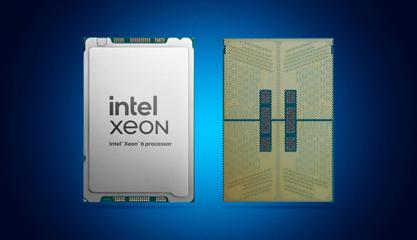

[Intel launches Xeon 6 and Gaudi 3 AI chips as stock languishes, takeover talk circulates.](https://venturebeat.com/ai/intel-launches-xeon-6-and-gaudi-3-ai-chips-to-boost-ai-and-hpc-performance/) - VentureBeat

___

Silicon Valley, where every dystopian nightmare movie or novel can be recycled into a business plan

how it started, how it's going

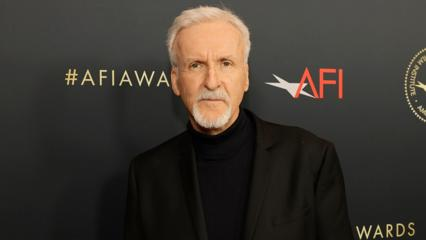

[Wasn't Terminator a cautionary tale about superintelligent AI?](https://www.hollywoodreporter.com/business/business-news/james-cameron-joins-board-ai-firm-stability-stable-diffusion-1236010034/) - The Hollywood Reporter

___

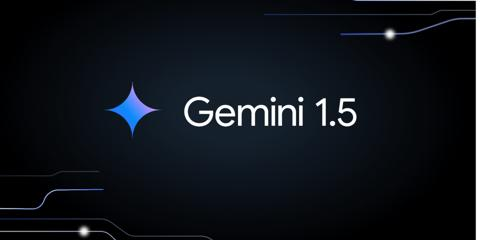

[Google updates models, cuts prices, undercutting 4o in a bit of a price war](https://developers.googleblog.com/en/updated-production-ready-gemini-models-reduced-15-pro-pricing-increased-rate-limits-and-more/)

___

You pay doctors, nurses, scientists to treat a disease like cancer or heart disease, it becomes a big business, you can create perverse incentives against cheap prevention or even cures.

[en.wikipedia.org/wiki/Goodhar... Also the 'cobra effect', where apocryphally Indians got a bounty for dead cobras, so they just started breeding cobras](https://en.wikipedia.org/wiki/Goodhart%27s_law)

___

It's been a success, payouts increased, and favor hustlers who move a lot of bikes vs. a casual user who just takes note of the best options. But then, the hustlers realized teams working together could create empty or full docks to maximize payouts, which actually reversed the incentive structure.

[GoodHart's low, or, when people find the flaw in the algorithm and game it. 

Citibike gives points when you balance out bike stations by taking a bike from a full station or returning a bike to an empty station. You can redeem 'Bike Angel' points against your subscription or on a debit card.](https://www.nytimes.com/2024/09/19/nyregion/citi-bike-scam-nyc.html)

___

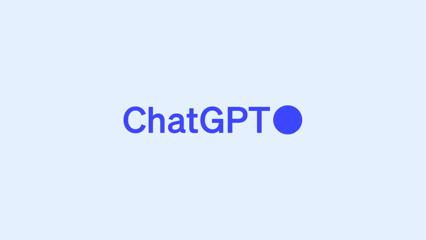

[Fully AI-generated AI newsletter is not terrible today

chatgpt.com/share/66f2d2...

notebook -](https://chatgpt.com/share/66f2d235-2978-8006-8672-0c4812b133f9) - ChatGPT

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [10]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [11]:
print(datetime.now())

2024-09-26 12:42:00.295581


In [12]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 9, 26, 16, 28, 15, 489000)

In [13]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-09-25 06:42:00.301429
